# Objective 
Evaluate 100 calibrated ensemble outputs for 4 model configurations

# Experiment description
* Chosen metric details (See: calib_metriceval_v2.ipynb): exp7 - Daily KGE, 1 day smoothing, kge_a_alpha = 1.
* 4 model runs
    * FUSE-PRMS
    * FUSE-HECHMS
    * FUSE-VIC
    * FUSE-SACSMA

In [1]:
import glob,os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [7]:
outdir = '/glade/work/manab/ff/islandpark/allout/calib100'
prms = sorted(glob.glob(outdir + '/*_111_runs_best*.nc'))
hechms = sorted(glob.glob(outdir + '/*_222_runs_best*.nc'))
vic = sorted(glob.glob(outdir + '/*_333_runs_best*.nc'))
sacsma = sorted(glob.glob(outdir + '/*_444_runs_best*.nc'))

prmsparam = sorted(glob.glob(outdir + '/*_111_para_best*.nc'))
hechmsparam = sorted(glob.glob(outdir + '/*_222_para_best*.nc'))
vicparam = sorted(glob.glob(outdir + '/*_333_para_best*.nc'))
sacsmaparam = sorted(glob.glob(outdir + '/*_444_para_best*.nc'))

In [25]:
print(prms[1])

/glade/work/manab/ff/islandpark/allout/calib100/002_111_runs_best.nc


In [8]:
def qextract(nclist, ncvar):
    '''
    Extracts the yearly maximums for all years and ensembles and concatenates them 
    into a single array
    
    nclist: List of all ensembles
    ncvar: Variable for which yearly maximum has to be calculated
    '''
    ncdat = np.empty([37,])
    for count, value in enumerate(nclist):
        ncout = xr.open_dataset(value)[ncvar]
        ncout = ncout.groupby('time.year').max()
        ncout = ncout.where((ncout.year > 1979), drop = True) #Time cutoff
        q = ncout.values
        ncdat = np.c_[ncdat, q]
        print('Extracting yearly maximums from ensemble ' + str(count+1) + ' of 100 \r', end='')
    #ncdat = np.delete(ncdat,(0), axis=1)
    return(ncdat)

def vextract(nclist, ncvar):
    '''
    Extracts any variable from each ensemble and concatenates them 
    into a single array
    
    nclist: List of all ensembles
    ncvar: Variable to be extracted
    '''
    var = np.empty([1,])
    for count, value in enumerate(nclist):
        nc = xr.open_dataset(value)
        ncv = nc[ncvar].values
        var = np.c_[var, ncv]
    
    var = np.delete(var,(0), axis=1)
    return(var)

In [10]:
# Prepare simulation data
prmsq = qextract(prms, 'q_routed')
hechmsq = qextract(hechms, 'q_routed')
vicq = qextract(vic, 'q_routed')
sacsmaq = qextract(sacsma, 'q_routed')

In [11]:
# Prepare observation data 
ncout = xr.open_dataset(sacsma[1])
ncout = ncout.groupby('time.year').max()
ncout = ncout.where((ncout.year > 1979), drop = True)
qobs = ncout['obsq'].values

# FLOW DURATION CURVES

In [12]:
def plotfdc(qdat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot exceedances of FUSE model outputs
    
    qdat: Simulation data
    qobs: Observation data
    pylabel: Y-axis plot label
    ptitle: Title of the plot
    psave: Plot name for saving
    
    '''
    # Calculate exceedance levels of sim data
    exceedanceens = np.arange(1.,len(qdat)+1) /len(qdat)
    sortens = np.sort(qdat, axis=0)[::-1]

    qmeandat = qdat.mean(axis=1)
    
    # Calculate exceedance levels of mean simulated data
    exceedancemean = np.arange(1.,len(qmeandat)+1) /len(qmeandat)
    sortmean = np.sort(qmeandat, axis=0)[::-1]
    
    # Calculate exceedance levels of obs data
    exceedanceobs = np.arange(1.,len(obsdat)+1) /len(obsdat)
    sortobs = np.sort(obsdat, axis=0)[::-1]
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8))
    plt.fill_between(exceedanceens*100, np.min(sortens, axis=1),np.max(sortens, axis=1), label = "Sim Q Ensemble")
    plt.plot(exceedancemean*100, sortmean, label = 'Sim Q Mean', color='red')
    plt.plot(exceedanceobs*100, sortobs, label = 'Obs Q', color='black')
    plt.xlabel("Exceedence [%]")
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()

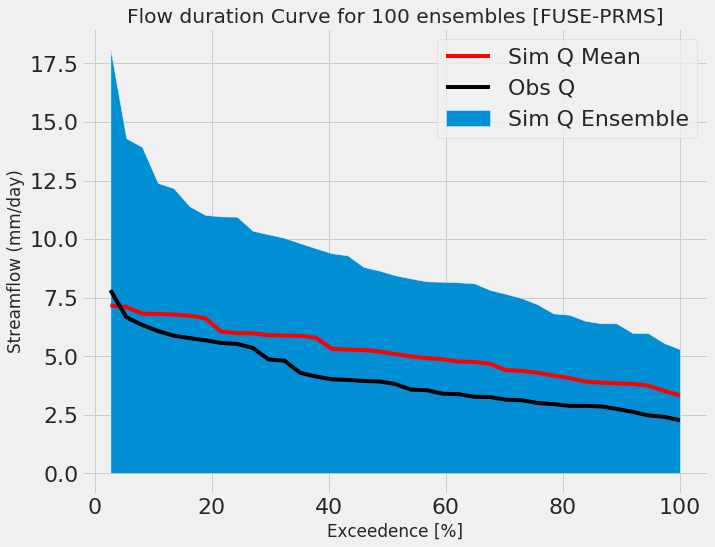

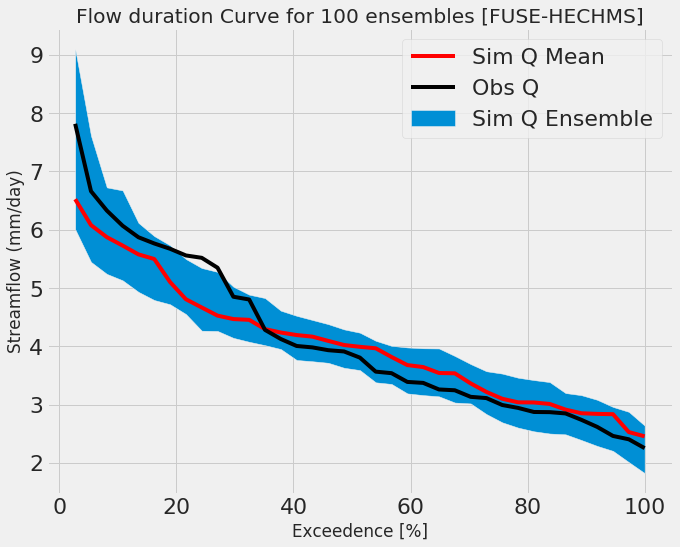

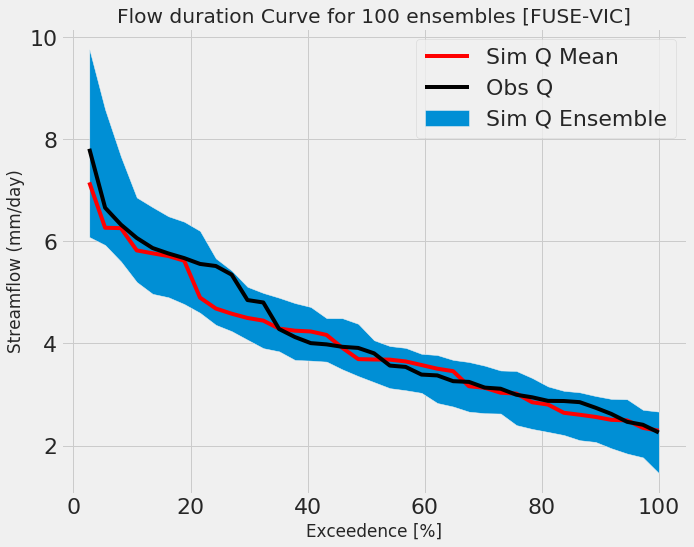

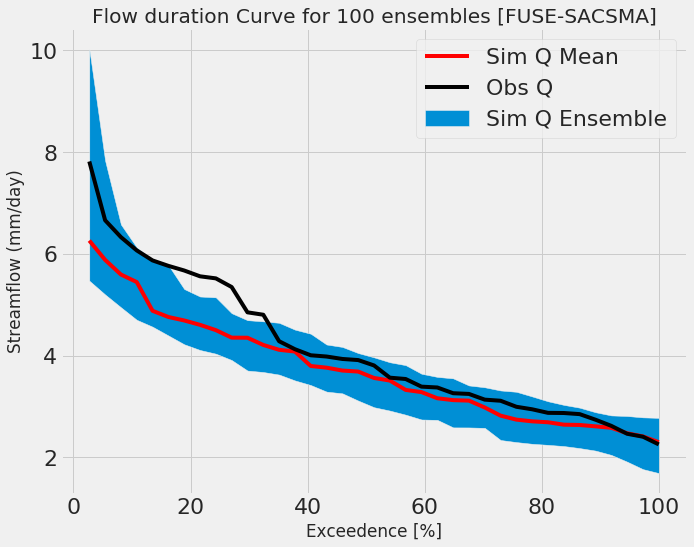

In [23]:
plotfdc(prmsq, qobs,'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-PRMS]', 'figures/fdcprms.png')
plotfdc(hechmsq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-HECHMS]', 'figures/fdchechms.png')
plotfdc(vicq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-VIC]', 'figures/fdcvic.png')
plotfdc(sacsmaq, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [FUSE-SACSMA]', 'figures/fdcsacsma.png')

# YEARLY PEAK FLOWS

In [14]:
def plotpeakq(qdat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot peak flows of FUSE model outputs
    '''
    sort = np.flipud(np.sort(qdat, axis=0)[::-1])
    
    # Prepare mean ensemble data
    meanq = qdat.mean(axis=1)
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8)) 
    plt.plot(sort, color='lightblue')
    plt.plot(np.sort(meanq), label = 'Mean Q', color='red')
    plt.plot(np.sort(obsdat), label = 'Obs Q', color='black')
    plt.xlabel('')
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()
    
# Prepare observation data 
ncout = xr.open_dataset(prms[1])
ncout = ncout.groupby('time.year').max()
ncout = ncout.where((ncout.year > 1979), drop = True)
qobs = ncout['obsq'].values

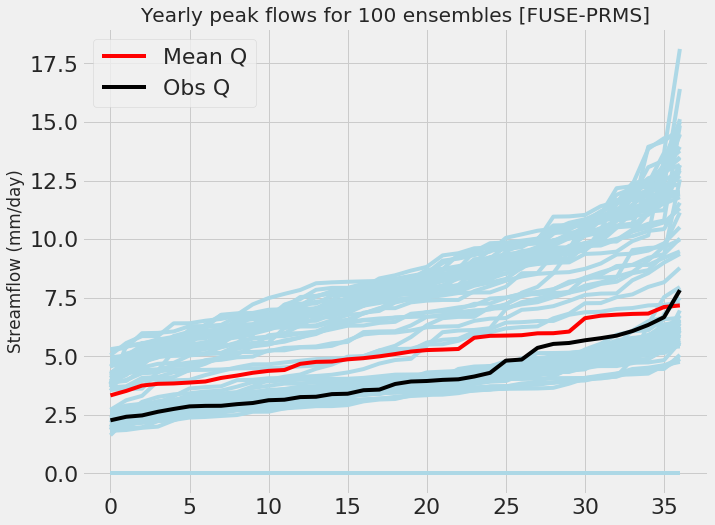

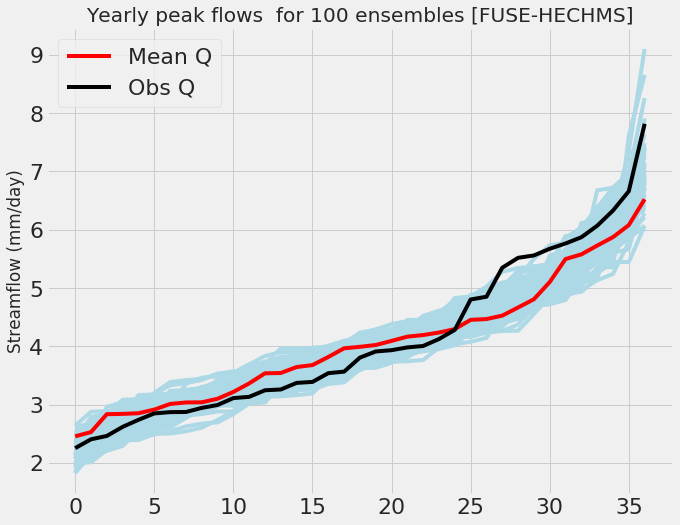

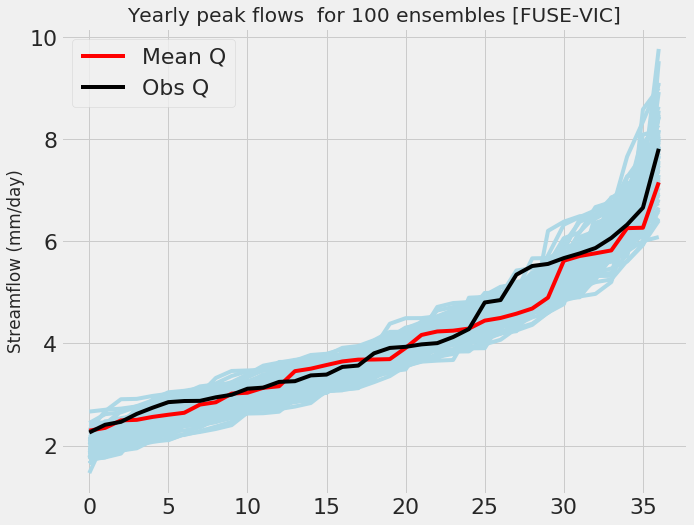

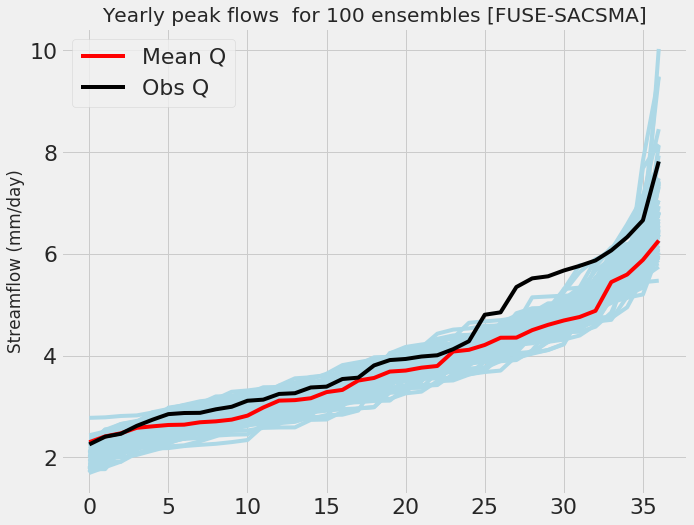

In [24]:
plotpeakq(prmsq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows for 100 ensembles [FUSE-PRMS]', 'figures/yearlyprms.png')
plotpeakq(hechmsq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [FUSE-HECHMS]', 'figures/yearlyhecshms.png')
plotpeakq(vicq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [FUSE-VIC]', 'figures/yearlyvic.png')
plotpeakq(sacsmaq, qobs,'Streamflow (mm/day)', 
          'Yearly peak flows  for 100 ensembles [FUSE-SACSMA]', 'figures/yearlysacsma.png')

# Empirical CDF

In [16]:
meanprms = prmsq.mean(axis=1)
meanhechms = hechmsq.mean(axis=1)
meanvic = vicq.mean(axis=1)
meansacsma = sacsmaq.mean(axis=1)

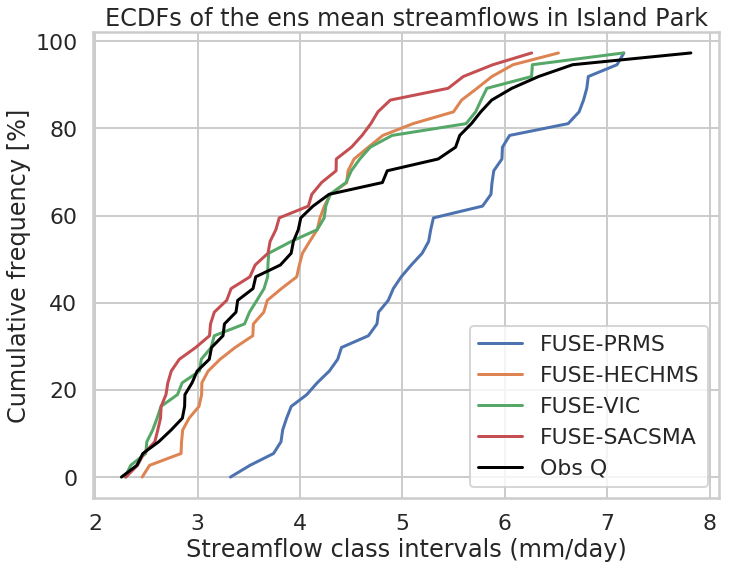

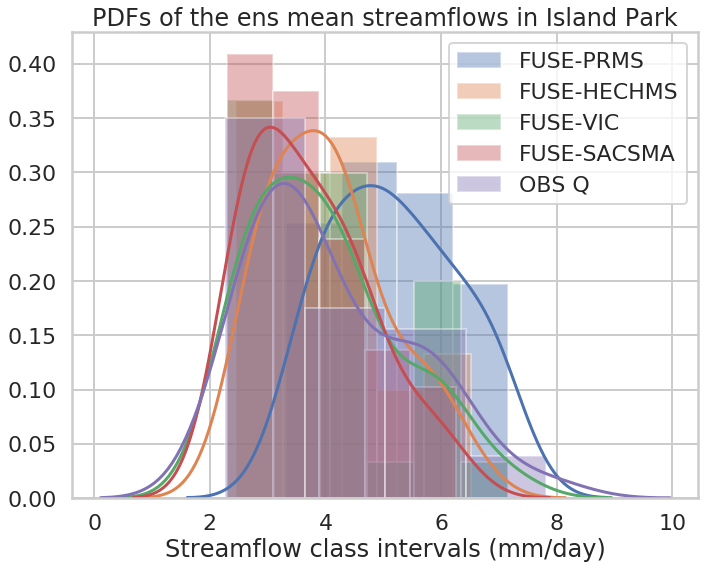

In [17]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid")
sns.set_context('poster')

# CDF PLOT
sns.lineplot(np.sort(meanprms), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'FUSE-PRMS')
plt.plot(np.sort(meanhechms), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'FUSE-HECHMS')
plt.plot(np.sort(meanvic), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'FUSE-VIC')
plt.plot(np.sort(meansacsma), np.linspace(0, 100, len(meanprms), endpoint=False), label = 'FUSE-SACSMA')
plt.plot(np.sort(qobs), np.linspace(0, 100, len(qobs), endpoint=False), label = 'Obs Q', color = 'black')
plt.ylabel('Cumulative frequency [%]')
plt.xlabel('Streamflow class intervals (mm/day)')
plt.title('ECDFs of the ens mean streamflows in Island Park')
plt.legend()
plt.savefig('figures/empiricalcdf.png', bbox_inches='tight', dpi=300)
plt.show()

# PDF PLOT
sns.distplot(meanprms, label='FUSE-PRMS')
sns.distplot(meanhechms, label='FUSE-HECHMS')
sns.distplot(meanvic, label='FUSE-VIC')
sns.distplot(meansacsma, label='FUSE-SACSMA')
sns.distplot(qobs, label='OBS Q')
plt.xlabel('Streamflow class intervals (mm/day)')
plt.title('PDFs of the ens mean streamflows in Island Park')
plt.legend()
plt.show()

# Range of KGE values

In [18]:
prmskge = vextract(prmsparam, 'kge')
hechmskge = vextract(hechmsparam, 'kge')
vickge = vextract(vicparam, 'kge')
sacsmakge = vextract(sacsmaparam, 'kge')


 RANGE of KGE values for 100 ensembles
Mean KGE (PRMS) : 0.308990376652
Max KGE (PRMS) : 0.775001883507
Min KGE (PRMS) : -0.678375542164
Mean KGE (HEC-HMS) : 0.746019592285
Max KGE (HEC-HMS) : 0.769161999226
Min KGE (HEC-HMS) : 0.705905854702
Mean KGE (VIC) : 0.769746571779
Max KGE (VIC) : 0.791582107544
Min KGE (VIC) : 0.732330799103
Mean KGE (SAC-SMS) : 0.790107845068
Max KGE (SAC-SMA) : 0.811881542206
Min KGE (SAC-SMA) : 0.691042780876


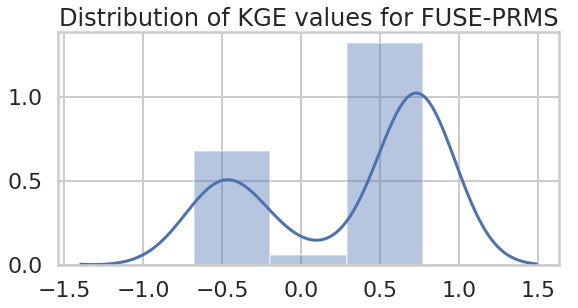

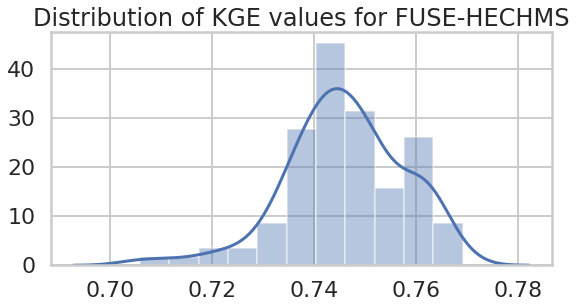

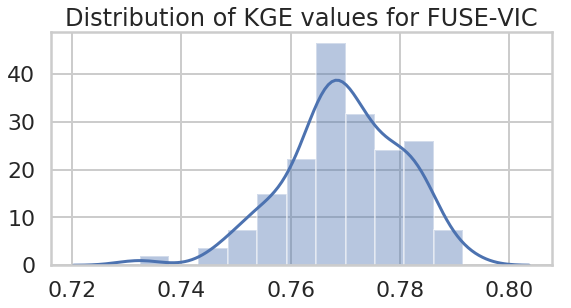

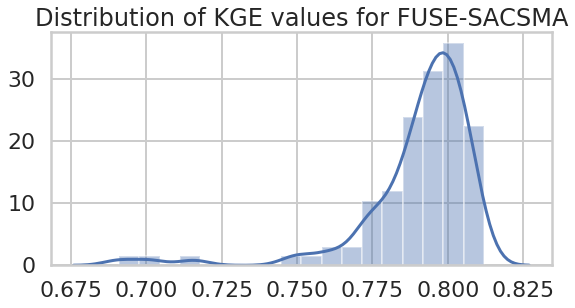

In [19]:
kge = {}
kge['Mean KGE (PRMS)'] = prmskge.mean()
kge['Max KGE (PRMS)'] = prmskge.max()
kge['Min KGE (PRMS)'] = prmskge.min()
kge['Mean KGE (HEC-HMS)'] = hechmskge.mean()
kge['Max KGE (HEC-HMS)'] = hechmskge.max()
kge['Min KGE (HEC-HMS)'] = hechmskge.min()
kge['Mean KGE (VIC)'] = vickge.mean()
kge['Max KGE (VIC)'] = vickge.max()
kge['Min KGE (VIC)'] = vickge.min()
kge['Mean KGE (SAC-SMS)'] = sacsmakge.mean()
kge['Max KGE (SAC-SMA)'] = sacsmakge.max()
kge['Min KGE (SAC-SMA)'] = sacsmakge.min()

print('\n RANGE of KGE values for 100 ensembles')
for x in kge:
    print (x,':',kge[x])

sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")
sns.set_context('poster')

sns.distplot(prmskge)
plt.title('Distribution of KGE values for FUSE-PRMS')
plt.show()
sns.distplot(hechmskge)
plt.title('Distribution of KGE values for FUSE-HECHMS')
plt.show()
sns.distplot(vickge)
plt.title('Distribution of KGE values for FUSE-VIC')
plt.show()
sns.distplot(sacsmakge)
plt.title('Distribution of KGE values for FUSE-SACSMA')
plt.show()

# Time-series plots of yearly maximum flows

In [20]:
def argmaxfunc(ds, dim=None):
    return ds.isel(**{dim: ds['q_routed'].argmax(dim)})


def yearlyVarMax(ncfile, ncvar, iyear):
    '''
    Extracts yearly max based on maximums of one variable
    '''
    ncdat = xr.open_dataset(ncfile)
    mask = ncdat[ncvar].isel(time=0).notnull()  # determine where you have valid data
    ncdat2 = ncdat.fillna(-9999)  # fill nans with a missing flag of some kind
    ncdat3 = ncdat2.groupby('time.year').apply(argmaxfunc, dim='time').where(mask) 
    ncdat4 = ncdat3.where((ncdat3.year > iyear), drop = True)
    return(ncdat4)

In [21]:
nc1=yearlyVarMax(prms[0], 'q_routed', 1980)
nc2=yearlyVarMax(hechms[0], 'q_routed', 1980)
nc3=yearlyVarMax(vic[0], 'q_routed', 1980)
nc4=yearlyVarMax(sacsma[0], 'q_routed', 1980)

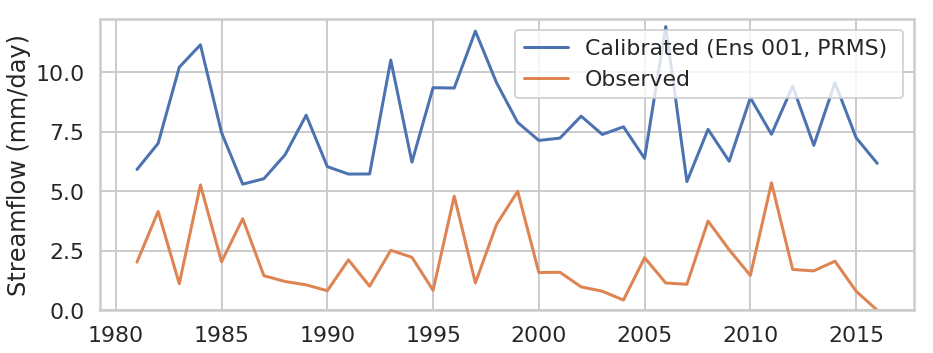

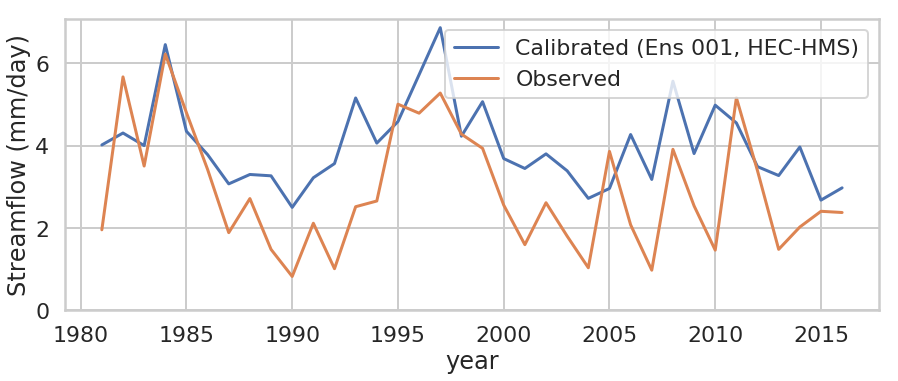

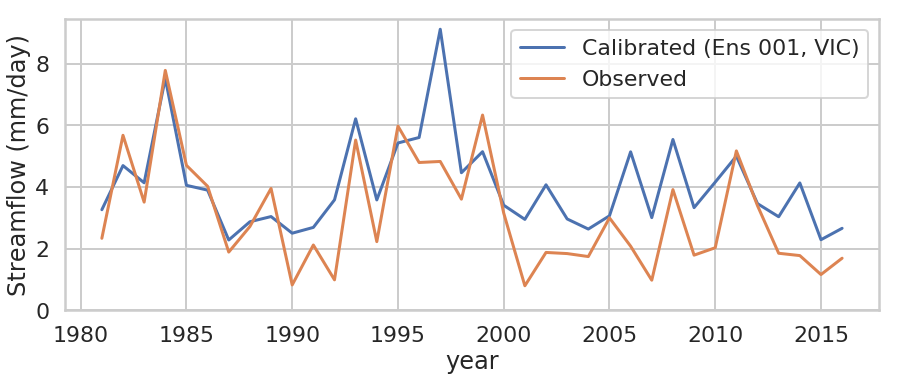

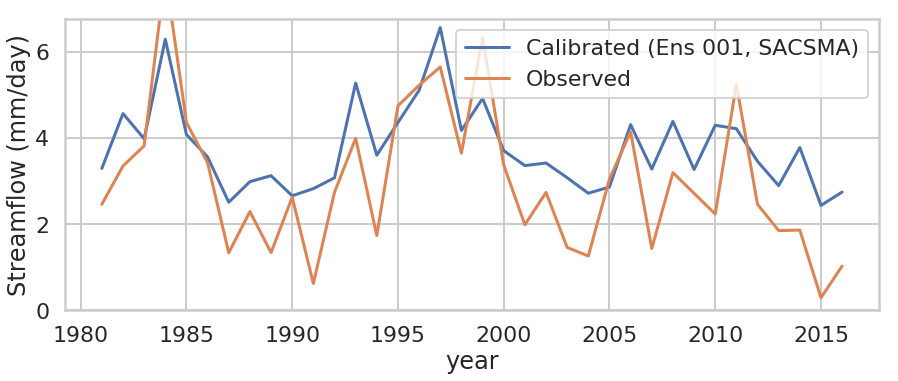

In [22]:
sns.set(rc={'figure.figsize':(13, 5)})
sns.set_style("whitegrid")
sns.set_context('poster')

nc1['q_routed'].plot(label = 'Calibrated (Ens 001, PRMS) ')
nc1['obsq'].plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('')
plt.ylim(0, )
plt.xlabel('')
plt.legend()
plt.savefig('figures/flowprms.png', bbox_inches='tight', dpi=300)
plt.show()

nc2['q_routed'].plot(label = 'Calibrated (Ens 001, HEC-HMS)')
nc2['obsq'].plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.ylim(0, )
plt.title('')
plt.legend()
plt.savefig('figures/flowhechms.png', bbox_inches='tight', dpi=300)
plt.show()

nc3['q_routed'].plot(label = 'Calibrated (Ens 001, VIC)')
nc3['obsq'].plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('')
plt.ylim(0, )
plt.legend()
plt.savefig('figures/flowvic.png', bbox_inches='tight', dpi=300)
plt.show()

nc4['q_routed'].plot(label = 'Calibrated (Ens 001, SACSMA)')
nc4['obsq'].plot(label = 'Observed')
plt.ylabel('Streamflow (mm/day)')
plt.title('')
plt.ylim(0, )
plt.legend()
plt.savefig('figures/flowsacsma.png', bbox_inches='tight', dpi=300)
plt.show()